In [240]:
def timeseries_country_dataX(country_name, dataX):
    
    """input: country_name (str), dataX (str) 
              --(dataX:= whichever column we want)
       output: dict. of values for dataX in yrs 1970-2022"""
   
    S_dataX = df[dataX].where(df[" Country "] == country_name)
    S_yrs = list(df[" Year "].where(df[" Country "] == country_name))
    L=[]
    dataX_dict={}
    
    for data in S_dataX:
        L.append(data)
    
    S1 = [x for x in L if (math.isnan(x) == False)]
    S2 = [x for x in S_yrs if (math.isnan(x) == False)]

    for i in range(len(S1)):
        dataX_dict[int(S2[i])] = S1[i]

    return dataX_dict


#timeseries_country_dataX(" Ireland ", " Gross Domestic Product (GDP) ")

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import sklearn
from sklearn.cluster import KMeans 
import statistics
import warnings
import re
import seaborn as sns
warnings.filterwarnings("ignore")

#cleaning df, excluding countries w/ missing values
df = pd.read_csv("csv/Global Economy Indicators.csv")
df = df[df[" Year "] >= 1990]
df = df[df[" Population "] >= 10**6]
df.drop([" AMA exchange rate ", " CountryID ", " Currency ", " Agriculture, hunting, forestry, fishing (ISIC A-B) " , " Changes in inventories ", " Construction (ISIC F) ", " Exports of goods and services ", " Final consumption expenditure ", " General government final consumption expenditure ", " Gross fixed capital formation (including Acquisitions less disposals of valuables) ", " Household consumption expenditure (including Non-profit institutions serving households) ", " Imports of goods and services ", " Manufacturing (ISIC D) ", " Gross capital formation ", " Mining, Manufacturing, Utilities (ISIC C-E) ", " Transport, storage and communication (ISIC I) ", " Wholesale, retail trade, restaurants and hotels (ISIC G-H) ", " Other Activities (ISIC J-P) "], axis = 1, inplace = True)

#deleting non-32-len countries
TBDel=[]
for country in sorted(set(df[" Country "])):
    if len(timeseries_country_dataX(country , " Gross Domestic Product (GDP) ").keys()) != 32:
        TBDel.append(country)

for country in TBDel:
    df = df.loc[df[" Country "] != country]

#149 countries w/ popul >= 1 000 0000
#df


In [242]:
def gdp_per_capita(country_name):

    """input: country_name (str)
       output: dict. of GDP/capita in yrs 1990-2022"""
    
    popul_dict = timeseries_country_dataX(country_name, " Population ")
    working_dict = timeseries_country_dataX(country_name, " Gross Domestic Product (GDP) ")
    
    for key in working_dict.keys():
        working_dict[key] = working_dict[key] / popul_dict[key]

    return working_dict


#gdp_per_capita(" Japan ")

In [243]:
def compute_ratios(country_name):
    
    """input: country_name(str)
       output: list of 'gradients' (f(i+1) / f(i))"""
    
    grad_list=[]
    gdp_list = list(gdp_per_capita(country_name).values())
    
    for i in range(len(gdp_list)):
        if i != len(gdp_list) - 1:
            grad_list.append(gdp_list[i+1] / gdp_list[i])
    return grad_list


#compute_ratios(" Switzerland ")

In [244]:
def compute_stdized_vals(country_name, p):
    
    """input: country_name, 0 or 1
       if p=0 -> output: std-ized gdp/capita list for country_name
       if p=1 -> output: std-ized ratios list for country_name"""

    L=[]
    sigma=0
    mean=0
    if p == 0:
        gpc_list = list(gdp_per_capita(country_name).values())
        mean = statistics.mean(gpc_list)
        sigma = statistics.stdev(gpc_list)
        for val in gpc_list:
            L.append((val - mean) / sigma)
    else:
        ratios_list = compute_ratios(country_name)
        mean = statistics.mean(ratios_list)
        sigma = statistics.stdev(ratios_list)
        for val in ratios_list:
            L.append(0.5 * ((val - mean) / sigma))
    return L

#compute_stdized_vals(" Switzerland ", 0)

In [245]:
def build_cvecs1():
    
    """Computes a unique 63d numpy vector for all countries
       based on compute_stdized_vals(p=0) and compute_stdized_vals(p=1)"""
    
    cvec_dict={}
    for country in set(df[" Country "]):
        cvec_dict[country] = np.array(compute_stdized_vals(country, 0) + compute_stdized_vals(country, 1))
    return cvec_dict


#build_cvecs1()

In [246]:
def labels_to_countries(label_array, no_clusters):
    
    """input: np array of labels set by clustering algorithm,
       number of clusters
       output: list that contains the lists of all clusters"""
    
    l_container = [[] for _ in range(no_clusters)]
    cvec_keys = list(build_cvecs1().keys())
    for i in range(len(label_array)):
        l_container[list(label_array)[i]].append(cvec_keys[i])
    return l_container



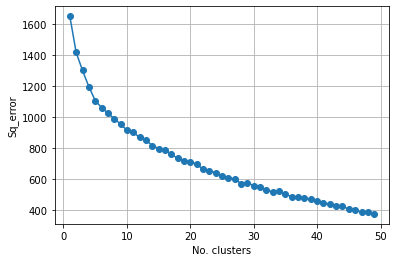

In [247]:
def optimise_kmeans(cvec_list, max_k=15):
    k_list=[]
    sq_errors=[]
    for k in range(1, max_k):
        kmeans = sklearn.cluster.KMeans(n_clusters=k)
        kmeans.fit(cvec_list)
        k_list.append(k)
        sq_errors.append(kmeans.inertia_)

    plt.plot(k_list, sq_errors, 'o-')
    plt.xlabel("No. clusters")
    plt.ylabel("Sq_error")
    plt.grid(True)
    plt.show()


optimise_kmeans(list(build_cvecs1().values()), 50)
        

In [248]:
#________KMeans________

cvec_list = list(build_cvecs1().values())
data = np.array(cvec_list)
kmeans = sklearn.cluster.KMeans(n_clusters=20, random_state=1).fit(data)
cvec_labels = labels_to_countries(kmeans.labels_, 20)
#cvec_labels

In [249]:
#cleaning educdata.csv dataframe (df2) to be compatible w/ initial dataframe (df)

df2 = pd.read_csv("csv/educdata.csv")

old_names=[]
new_names=[]

for name in set(df[" Country "]):
    old_names.append(name)
old_names.sort()
#print(old_names)


for name in set(df2["Country Name"]):
    if name != ("Data from database: World Development Indicators" and "Last Updated: 03/28/2024") and type(name) == str:
        new_names.append(name)
new_names.sort()
#print(new_names)

counter=0
counter2=0
new_names2=[]

for name in new_names:
    new_names2.append(name)

for name in new_names2:
    if (" " + name + " ") not in old_names:
        df2 = df2.loc[df2["Country Name"] != name]
        new_names.remove(name)
        #counter += 1




In [250]:
def row_averages_dict(df):

    """input: pandas dataframe
       output: a dictionary, keys=1st element in each row
                             values=row mean for each row"""
    
    row_avg_dict = {}
    first_element_count = {}
    for index, row in df.iterrows():
        first_element = row.iloc[0]
        if first_element in first_element_count:
            first_element_count[first_element] += 1
            key = f"{first_element}_{first_element_count[first_element]}"
        else:
            first_element_count[first_element] = 1
            key = first_element
        
        row_values = row.iloc[1:]
        row_values = row_values.dropna()  # Drop missing values
        # Remove non-numeric characters
        row_values = row_values.apply(lambda x: re.sub(r'[^0-9.]', '', str(x)))
        # Convert to numeric and drop non-numeric values
        row_values = pd.to_numeric(row_values, errors='coerce')
        row_values = row_values.dropna()
        if len(row_values) > 0:
            row_avg = row_values.mean()
            row_std = row_values.std()
            row_avg_dict[key] = (row_avg, row_std)
    return row_avg_dict


#row_averages_dict(df2)

In [251]:
def stdized_edu_vals(row_averages_dict):
    
    """input: row_averages_dict
       output: dict of 2-tuples, which contain
       the standarized values of the row_averages_dict,
       for each key in row_averages_dict"""

    D={}
    mean1=0
    mean2=0
    sigma=0
    sigma2=0
    sigma_list1=[]
    sigma_list2=[]
    
    for key in row_averages_dict:
        if key[-1] != "2":
            mean1 += row_averages_dict[key][0]
        else:
            mean2 += row_averages_dict[key][0]
        if row_averages_dict[key][1] >= 0:
            if key[-1] != "2":
                sigma_list1.append(row_averages_dict[key][1])
            else:
                sigma_list2.append(row_averages_dict[key][1])
    mean1 = mean1 / (len(row_averages_dict.keys()) / 2)
    mean2 = mean2 / (len(row_averages_dict.keys()) / 2)
    sigma1 = statistics.stdev(sigma_list1)
    sigma2 = statistics.stdev(sigma_list2)
    
    for key in row_averages_dict.keys():
        if key[-1] != "2":
            D[key] = (row_averages_dict[key][0] - mean1) / sigma1
        else:
            D[key] = (row_averages_dict[key][0] - mean2) / sigma2
    return D

#stdized_edu_vals(row_averages_dict(df2))
    

In [252]:
def build_eduvecs(D):
    edu_vecs={}
    key2=""
    for key in D.keys():
        if (key[-1] != "2") and ((key+"_2") in list(D.keys())):
            key2 = key + "_2"
            edu_vecs[key] = np.array([D[key], D[key2]])
    return edu_vecs

#build_eduvecs(stdized_edu_vals(row_averages_dict(df2)))

In [253]:
def plot_eduvecs(data):
    for key, array in data.items():
        if array.size >= 2:
            plt.scatter(array[0], array[1], label=str(key))

    plt.xlabel('School enrollment, tertiary (%)')
    plt.ylabel('Government expenditure on education (% of GDP)')
    plt.title('Edu data scatter plot (normalized)')
    plt.grid(True)
    plt.show()

#plot_eduvecs(build_eduvecs(stdized_edu_vals(row_averages_dict(df2))))

In [254]:
def delete_outliers(eduvecs):
    eduvecs_new = eduvecs.copy()
    for key in eduvecs.keys():
        if (float(eduvecs[key][1]) > 3) or (float(eduvecs[key][1]) < (-3)) or (float(eduvecs[key][0]) > 6):
            del eduvecs_new[key]
    return eduvecs_new


#plot_eduvecs(delete_outliers(build_eduvecs(stdized_edu_vals(row_averages_dict(df2)))))


In [255]:
def labels_to_eduvecs(label_array, no_clusters):
    
    """input: np array of labels set by clustering algorithm,
       number of clusters
       output: list that contains the lists of all clusters"""
    
    l_container = [[] for _ in range(no_clusters)]
    eduvec_keys = list(build_eduvecs(stdized_edu_vals(row_averages_dict(df2))).keys())
    for i in range(len(label_array)):
        l_container[list(label_array)[i]].append(eduvec_keys[i])
    return l_container


In [256]:
#Finding ideal no. of clusters for edu data

#optimise_kmeans(list(build_eduvecs(stdized_edu_vals(row_averages_dict(df2))).values()), 50)

In [257]:
#________KMeans2________

eduvec_list = list(build_eduvecs(stdized_edu_vals(row_averages_dict(df2))).values())
data2 = np.array(eduvec_list)
kmeans2 = sklearn.cluster.KMeans(n_clusters=20).fit(data2)
eduvec_labels = labels_to_eduvecs(kmeans2.labels_, 20)

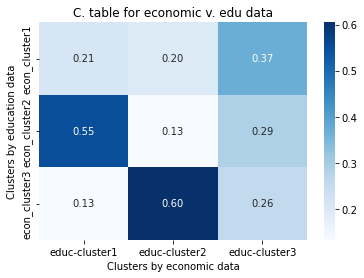

In [258]:
def create_contingency_table(U, V):

    """input: 2 lists of lists
       output: contingency table of the inner lists"""
    
    U_filtered = [ulist for ulist in U if len(ulist) > 1]
    V_filtered = [vlist for vlist in V if len(vlist) > 1]
    

    U_sets = [set(u.strip() for u in ulist) for ulist in U_filtered]
    V_sets = [set(v) for v in V_filtered]
    
    r = len(U_sets)
    c = len(V_sets)
    contingency_table = [[0] * c for _ in range(r)]
    
    for i in range(r):
        for j in range(c):
            mean_size = (len(U_filtered[i]) + len(V_filtered[j])) / 2
            contingency_table[i][j] = len(U_sets[i].intersection(V_sets[j])) / mean_size
    
    return contingency_table

def plot_contingency_table(table, row_labels, col_labels):
    sns.heatmap(table, annot=True, fmt=".2f", cmap="Blues", xticklabels=col_labels, yticklabels=row_labels)
    plt.xlabel('Clusters by economic data')
    plt.ylabel('Clusters by education data')
    plt.title('C. table for economic v. edu data')
    plt.show()
    

kmeans = sklearn.cluster.KMeans(n_clusters=3, random_state=0).fit(data)
kmeans2 = sklearn.cluster.KMeans(n_clusters=3, random_state=0).fit(data2)
U = labels_to_countries(kmeans.labels_, 3)
V = labels_to_eduvecs(kmeans2.labels_, 3)
contingency_table = create_contingency_table(U, V)

# Generate row and column labels excluding 1-long lists
row_labels = [f'econ_cluster{i+1}' for i, ulist in enumerate(U) if len(ulist) > 1]
col_labels = [f'educ-cluster{i+1}' for i, vlist in enumerate(V) if len(vlist) > 1]

plot_contingency_table(contingency_table, row_labels, col_labels)

In [259]:
def export():
    cvec_indexes = []
    cvec_countries = []
    for sub_array in cvec_labels:
        for item in sub_array:
            cvec_indexes.append(cvec_labels.index(sub_array))
            cvec_countries.append(item)

    cvec_df = pd.DataFrame({
        'Country' : cvec_countries,
        'K_index' : cvec_indexes
    })


    eduvec_indexes = []
    eduvec_countries = []
    for sub_array in eduvec_labels:
        for item in sub_array:
            eduvec_indexes.append(eduvec_labels.index(sub_array))
            eduvec_countries.append(item)

    eduvec_df = pd.DataFrame({
        'Country' : eduvec_countries,
        'K_index' : eduvec_indexes
    })

    eduvec_df.to_csv('csv_ered/oktatasi.csv', index=False)
    cvec_df.to_csv('csv_ered/gazdasagi.csv', index=False)